# 1. Project Topic

GitHub Repo: https://github.com/wr0b1n/MSDS-5511-Week5

In this competition, we will use Generative Adversarial Networks (GANs) to recreate Claude Monet's artistic style in images. GANs consist of a generator and discriminator, where the generator produces Monet-style images, and the discriminator distinguishes real from generated ones. The goal is to generate 7,000 to 10,000 Monet-style images that will be evaluated on the MiFID (Memorization-informed Fréchet Inception Distance).

Generative Deep Learning models are a subset of deep learning models designed to generate new data samples that resemble a given dataset. These models are used in various applications, such as image generation, text generation, and more. The key idea behind generative models is to learn the underlying distribution of the training data and then sample from this distribution to create new data samples.

GANs in particular are a powerful class of generative models that consist of two neural networks, namely a generator and a discriminator that are trained adversarially. The goal of the generator is to create realistic data samples, while the discriminator tries to decide between real and fake samples. This adversarial training process results in the generator improving its ability to produce high-quality, realistic data.

# 2. Data

We are provided with monet paintings both in JPG and TFRecords format as our training data. In case of the JPG data we have about 300 image files. For generating new images we are provided with 7038 photos (again in JPG and TFRecords format). These photos will be manipulated by our model in order get the monet style and make them look like real monet paintings.

Since we are working with a large amount of image data we will probably face extremely long computation time. For this reason we will need to activate the TPU accelerator in the Kaggle notebook.

Both the monet paintings as well as the photos have a size of 256x256 pixels. The submission format is a zip-file containing 7,000-10,000 images sized 256x256 as well. 

# 3. Import Python Libraries

Let's import the most important libraries for our project.

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os
import math
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
from torch.utils.data import Dataset, random_split, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms

from tqdm.notebook import tqdm
import itertools
import time
import shutil

In [2]:
import torch
import torch.nn as nn

# Function to calculate tensor size
def calculate_size(input_size, layer):
    with torch.no_grad():
        input_tensor = torch.randn(input_size)
        output_tensor = layer(input_tensor)
    return output_tensor.size()

# Model architecture
in_ch = 3
out_ch = 3

model = [
    nn.Conv2d(in_ch, 64, 3, 2, 1, bias=True),
    nn.ReLU(),
    nn.Conv2d(64, 128, 3, 1, 1, bias=True),
    nn.Dropout(0.3),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm2d(128),
    nn.Conv2d(128, 256, 5, 2, 1, bias=True),
    nn.LeakyReLU(negative_slope=0.03, inplace=True),
    nn.InstanceNorm2d(256),
    nn.ReflectionPad2d(1),
    nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
    nn.ReLU(),
    nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0),
    nn.Dropout(0.2),
    nn.LeakyReLU(negative_slope=0.01, inplace=True),
    nn.BatchNorm2d(64),
    nn.Conv2d(64, out_ch, kernel_size=6, padding=1),
    nn.Tanh(),
]

# Input size
input_size = (1, in_ch, 256, 256)

# Calculate and print sizes for each layer
for layer in model:
    output_size = calculate_size(input_size, layer)
    print(f"Layer: {layer.__class__.__name__}, Target Size: {output_size}")
    input_size = output_size


Layer: Conv2d, Target Size: torch.Size([1, 64, 128, 128])
Layer: ReLU, Target Size: torch.Size([1, 64, 128, 128])
Layer: Conv2d, Target Size: torch.Size([1, 128, 128, 128])
Layer: Dropout, Target Size: torch.Size([1, 128, 128, 128])
Layer: LeakyReLU, Target Size: torch.Size([1, 128, 128, 128])
Layer: BatchNorm2d, Target Size: torch.Size([1, 128, 128, 128])
Layer: Conv2d, Target Size: torch.Size([1, 256, 63, 63])
Layer: LeakyReLU, Target Size: torch.Size([1, 256, 63, 63])
Layer: InstanceNorm2d, Target Size: torch.Size([1, 256, 63, 63])
Layer: ReflectionPad2d, Target Size: torch.Size([1, 256, 65, 65])
Layer: ConvTranspose2d, Target Size: torch.Size([1, 128, 130, 130])
Layer: ReLU, Target Size: torch.Size([1, 128, 130, 130])
Layer: ConvTranspose2d, Target Size: torch.Size([1, 64, 259, 259])
Layer: Dropout, Target Size: torch.Size([1, 64, 259, 259])
Layer: LeakyReLU, Target Size: torch.Size([1, 64, 259, 259])
Layer: BatchNorm2d, Target Size: torch.Size([1, 64, 259, 259])
Layer: Conv2d, Tar

# 4. EDA and Data Preprocessing

First, we have to determine the paths were our image data is located and have a look at how many images we are working with.

In [3]:
# access folders
path_monet = "../input/gan-getting-started/monet_jpg/"
path_photo = "../input/gan-getting-started/photo_jpg/"

print("Number of monet paintings: {}".format(len(os.listdir(path_monet))))
print("Number of photos: {}".format(len(os.listdir(path_photo))))

Number of monet paintings: 300
Number of photos: 7038


Now, let's display some example images, both monet and real photos.

As we can see monet paintings have that distinctive style that many of us instantly relate to the famous painter called Monet. The photos on the other hand seem to be taken with a normal camera. Both types of images are colored ones, not just black and white.

We can verify the stated image sizes from the kaggle description by inspecting the width and height of both the monet paintings as well as the real photos.

As we can see in the histograms all images are indeed of size 256x256 pixels. Next, we will have a look at how the different color channels are distributed in the images. 

The above plots show the color channels for three monet paintings respectively photos. We could now ask the question if a certain color channel is more present in the monet paintings than in the photos.

The bar plot shows us that all color channels (Red, Green, Blue) have higher average values in Monet's paintings compared to normal photos. This makes sense since Monet is known for his impressionist style which often uses intense colors to capture the play of light and atmosphere. They tend to have a richer and more saturated color palette. This characteristic aligns with Monet's artistic style, where he emphasized the use of color to show emotions and capture the essence of a scene rather than adhering to strict color realism. Now that we are fimiliar with the given data we can begin with model building.

# 5. Model Building

As we already know Generative Adversarial Network (GAN) is a type of machine learning model consisting of a generator and a discriminator that compete against each other to produce realistic data. In this project we will work with CycleGAN which is a specific GAN variant used for image-to-image translation tasks without paired data. It employs two generators and two discriminators to enable translating images from one domain to another while ensuring that the translations are consistent when reversed. This is commonly used for tasks like style transfer and image transformation.

Since we are working with neural networks and image data we will make use of the Kaggle GPU to reduce running time of the notebook. 

In [4]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device used for modeling: ", device)

Device used for modeling:  cuda


## 5.1 Dataset and Dataloader

First we create a dataset for training our generative model. It takes the two directories where our monet paintings and photos can be found. The class loads and preprocesses the images, applying resizing and optionally normalization to create a consistent input for our neural network. With the __getitem__ method, we can randomly select a Monet-style image and the corresponding photo, processes them, and returns them as tensors. The __len__ method returns the length of the smaller of the two sets of images, ensuring that the dataset is limited by the number of available pairs.

In [5]:
class ImageDataset(Dataset):
    def __init__(self, path_monet, path_photo, size=(256, 256), normalize=True):
        super().__init__()
        self.monet_dir = path_monet
        self.photo_dir = path_photo
        self.monet_idx = dict()
        self.photo_idx = dict()
        
        # normalize the images for consistency
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()])
            
        for i, fl in enumerate(os.listdir(self.monet_dir)):
            self.monet_idx[i] = fl
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    # randomnly select a pair of monet painting and photo
    def __getitem__(self, idx):
        rand_idx = int(np.random.uniform(0, len(self.monet_idx.keys())))
        photo_path = os.path.join(self.photo_dir, self.photo_idx[rand_idx])
        monet_path = os.path.join(self.monet_dir, self.monet_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        monet_img = Image.open(monet_path)
        monet_img = self.transform(monet_img)
        return photo_img, monet_img

    # ensure same amount of available photos
    def __len__(self):
        return min(len(self.monet_idx.keys()), len(self.photo_idx.keys()))

In [6]:
img_ds = ImageDataset(path_monet, path_photo)
img_dl = DataLoader(img_ds, batch_size=1, pin_memory=True)

The following is a helper method that performs the reverse operation of normalizing an image. Since our model only works with normalized versions of the images, this is needed for plotting the original version of the images after modeling them.

In [7]:
# reverse the normalization process
def reverse_normalize(img, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]):
    for image, mu, std in zip(img, mean, std):
        image.mul_(std).add_(std)
        
    return img

## 5.2 Model building blocks

The upsampling part is important for increasing the spatial resolution of an image. It is typically used in the generator network to gradually upsample the feature maps, which helps in generating higher-resolution output images from lower-resolution input images.

The purpose of the following method is to define the logic for upsampling within a neural network. The choice of whether to use dropout or not is controlled by the use_dropout argument, providing more flexibility in designing the generator architecture.

In [8]:
# method for upsampling feature maps
def Upsample(in_ch, out_ch, use_dropout=True, dropout_ratio=0.5):
    if use_dropout:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.Dropout(dropout_ratio),
            nn.GELU())
    else:
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 3, stride=2, padding=1, output_padding=1),
            nn.InstanceNorm2d(out_ch),
            nn.GELU())

Next, we need the convolutional layer which is responsible for extracting features from the input images. These layers apply convolution operations to process the image data and capture important patterns and details. They are used both in the generator and discriminator networks.

The below method returns a PyTorch Sequential object that can be used to create the architecture of both the generator and discriminator in a CycleGAN model. The flexibility provided by the function's arguments allows for different architectural choices.

In [9]:
# define a convolutional layer with options for padding and more
def Convlayer(in_ch, out_ch, kernel_size=3, stride=2, use_leaky=True, use_inst_norm=True, use_pad=True):
    if use_pad:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 1, bias=True)
    else:
        conv = nn.Conv2d(in_ch, out_ch, kernel_size, stride, 0, bias=True)

    if use_leaky:
        actv = nn.LeakyReLU(negative_slope=0.2, inplace=True)
    else:
        actv = nn.GELU()

    if use_inst_norm:
        norm = nn.InstanceNorm2d(out_ch)
    else:
        norm = nn.BatchNorm2d(out_ch)

    return nn.Sequential(conv, norm, actv)

The Residual Block is part of the generator network. Its purpose is to make the network learn residual functions, which help preserve important details and prevent vanishing gradients during training. This is particularly useful for maintaining image quality and consistency during the translation process.

In [10]:
# defines the residual block for the generator part
class Resblock(nn.Module):
    def __init__(self, in_features, use_dropout=True, dropout_ratio=0.5):
        super().__init__()
        layers = list()
        layers.append(nn.ReflectionPad2d(1))
        layers.append(Convlayer(in_features, in_features, 3, 1, False, use_pad=False))
        layers.append(nn.Dropout(dropout_ratio))
        layers.append(nn.ReflectionPad2d(1))
        layers.append(nn.Conv2d(in_features, in_features, 3, 1, padding=0, bias=True))
        layers.append(nn.InstanceNorm2d(in_features))
        self.res = nn.Sequential(*layers)

    def forward(self, x):
        return x + self.res(x)

The generator is the component responsible for translating images from one domain to another. It takes an input image (e.g., a photo) and transforms it into an image that mimics the style or characteristics of another domain (e.g., a Monet painting). The purpose of the generator is to learn a mapping between these domains and generate high-quality images in the target domain.

The class below represents this generator and defines the architecture and operations needed to perform the image translation task. It makes use of the Upsampling, Convolutional Layers, and ResBlock which we defined above.

In [11]:
# defines the generator class built upon convolutional layers
class Generator(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        """
        model = list()
        model.append(nn.ReflectionPad2d(3))
        model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
        model.append(Convlayer(64, 128, 3, 2, False))
        model.append(Convlayer(128, 256, 3, 2, False))
        for _ in range(num_res_blocks):
            model.append(Resblock(256))
        model.append(Upsample(256, 128))
        model.append(Upsample(128, 64))
        model.append(nn.ReflectionPad2d(3))
        model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
        model.append(nn.Tanh())
        """
        model = list()
        model.append(nn.Conv2d(in_ch, 64, 3, 2, 1, bias=True))
        model.append(nn.ReLU())
        model.append(nn.Conv2d(64, 128, 3, 1, 1, bias=True))
        model.append(nn.Dropout(0.3))
        model.append(nn.LeakyReLU(negative_slope=0.01,inplace=True))
        model.append(nn.BatchNorm2d(128))
        model.append(nn.Conv2d(128,256,5,2,1,bias=True))
        model.append(nn.LeakyReLU(negative_slope=0.03,inplace=True))
        model.append(nn.InstanceNorm2d(256))
        model.append(nn.ReflectionPad2d(1))
        model.append(nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1))
        model.append(nn.ReLU())
        model.append(nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0))
        model.append(nn.Dropout(0.2))
        model.append(nn.LeakyReLU(negative_slope=0.01,inplace=True))
        model.append(nn.BatchNorm2d(64))
        model.append(nn.Conv2d(64, out_ch, kernel_size=6, padding=1))
        model.append(nn.Tanh())
        self.gen = nn.Sequential(*model)

    def forward(self, x):
        return self.gen(x)

The discriminator is the component responsible for distinguishing between real and generated images. Its purpose is to provide feedback to the generator by assessing the realism of the generated images and helping the generator improve over time. The discriminator is trained to classify input images as either real (belonging to the target domain) or fake (generated by the generator).

In [12]:
# defines the discriminator component
class Discriminator(nn.Module):
    def __init__(self, in_ch, num_layers=4):
        
        super().__init__()
        model = list()
        """
        model.append(nn.Conv2d(in_ch, 64, 4, stride=2, padding=1))
        model.append(nn.LeakyReLU(0.2, inplace=True))
        for i in range(1, num_layers):
            in_chs = 64 * 2**(i-1)
            out_chs = in_chs * 2
            if i == num_layers -1:
                model.append(Convlayer(in_chs, out_chs, 4, 1))
            else:
                model.append(Convlayer(in_chs, out_chs, 4, 2))
        model.append(nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1))
        """
        model.append(nn.Conv2d(in_ch, 64,3,stride=1,padding=1))
        model.append(nn.Dropout(0.1))
        model.append(nn.ReLU())
        model.append(nn.BatchNorm2d(64))
        model.append(nn.Conv2d(64,128,4,stride=2,padding=1))
        model.append(nn.LeakyReLU(negative_slope=0.02,inplace=True))
        model.append(nn.Conv2d(128,1,4,stride=1,padding=1))
        
        
        self.disc = nn.Sequential(*model)

    def forward(self, x):
        return self.disc(x)

As with deep learning in general we also need a weight initialization in CycleGAN to set the initial values of the model's weights in a way that helps improve the training process and convergence speed. This is really important since a proper weight initialization can prevent issues like vanishing gradients and allow the model to learn more effectively.

In [13]:
# initalize with normally distributed weights around mean 0 and standard deviation of 0.02
def init_weights(net, init_type='normal', std=0.02):
    def init_func(m):
        classname = m.__class__.__name__
        if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
            init.normal_(m.weight.data, 0.0, std)
            if hasattr(m, 'bias') and m.bias is not None:
                init.constant_(m.bias.data, 0.0)
        elif classname.find('BatchNorm2d') != -1:
            init.normal_(m.weight.data, 1.0, std)
            init.constant_(m.bias.data, 0.0)
    net.apply(init_func)

## 5.3 Cycle GAN

First, we will need some additional helper methods that are explained and defined below.

The purpose of the first function is to provide a convenient way to control whether the parameters of a list of models should be trainable (require gradients) or frozen (not require gradients) during training. This can be useful in scenarios where you want to fine-tune certain parts of a pre-trained model while keeping others fixed, or when you want to selectively train or freeze specific model components during different training phases.

In [14]:
# decide whether certain model parameters should be trainable or not
def update_req_grad(models, requires_grad=True):
    for model in models:
        for param in model.parameters():
            param.requires_grad = requires_grad

The purpose of the "sample fake" mechanism in CycleGAN is to help stabilize training by sampling a subset of generated fake images and using them as inputs to the discriminator. This approach is used to reduce the variability in the inputs to the discriminator, which can help avoid large oscillations in the discriminator's outputs from one training iteration to the next. By doing so, it can make the training process more stable and lead to better convergence.

For this reason we provide a method seen below to control the number of fake images used for each training iteration and introduce a level of randomness in the selection of fake images to stabilize training in CycleGAN.

In [15]:
# class to save 50 generated fake images and sample through them to feed discriminator
class sample_fake(object):
    def __init__(self, max_imgs=50):
        self.max_imgs = max_imgs
        self.cur_img = 0
        self.imgs = list()

    def __call__(self, imgs):
        ret = list()
        for img in imgs:
            if self.cur_img < self.max_imgs:
                self.imgs.append(img)
                ret.append(img)
                self.cur_img += 1
            else:
                if np.random.ranf() > 0.5:
                    idx = np.random.randint(0, self.max_imgs)
                    ret.append(self.imgs[idx])
                    self.imgs[idx] = img
                else:
                    ret.append(img)
        return ret

The purpose of learning rate scheduling is to dynamically adjust the learning rate during training to optimize the convergence of the neural network. Learning rate scheduling typically involves reducing the learning rate over time to help the model converge more smoothly and reach a better minimum of the loss function.

By using this linear decay strategy, the learning rate gradually decreases as training progresses beyond **self.decay_epochs**. It's a simple yet effective way to improve training stability.

In [16]:
# class to schedule the learning rate during training
class lr_sched():
    def __init__(self, decay_epochs=100, total_epochs=200):
        self.decay_epochs = decay_epochs
        self.total_epochs = total_epochs

    def step(self, epoch_num):
        if epoch_num <= self.decay_epochs:
            return 1.0
        else:
            fract = (epoch_num - self.decay_epochs)  / (self.total_epochs - self.decay_epochs)
            return 1.0 - fract
            #return 0.9 ** (epoch_num - self.decay_epochs)

Finally, we define a class that is able to collect and track important statistics, like loss values and iteration numbers, over the course of training. These statistics can be used for various purposes, such as monitoring the training progress, visualizing loss curves, or making decisions about model training.

In [17]:
# class for saving some training metrics
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.its = []
        
    def append(self, loss, it):
        self.losses.append(loss)
        self.its.append(it)

The following class defines the Cycle GAN itself together with the required training loop. It trains the model to translate images between the two domains (photos and Monet paintings). It includes the training logic for both generators and discriminators, learning rate scheduling, and tracking of training statistics. The model's losses are backpropagated, and the parameters are updated accordingly during training.

In [18]:
# defines the Cycle GAN and its training loop
class CycleGAN(object):
    def __init__(self, in_ch, out_ch, epochs, device, start_lr=2e-4, lmbda=10, idt_coef=0.5, decay_epoch=0):
        self.epochs = epochs
        self.decay_epoch = decay_epoch if decay_epoch > 0 else int(self.epochs/2)
        self.lmbda = lmbda
        self.idt_coef = idt_coef
        self.device = device
        self.gen_mtp = Generator(in_ch, out_ch)
        self.gen_ptm = Generator(in_ch, out_ch)
        self.desc_m = Discriminator(in_ch)
        self.desc_p = Discriminator(in_ch)
        self.init_models()
        self.mse_loss = nn.MSELoss()
        self.l1_loss = nn.L1Loss()
        #self.adam_gen = torch.optim.Adam(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
        #                                 lr = start_lr, betas=(0.5, 0.999))
        #self.adam_desc = torch.optim.Adam(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
        #                                  lr=start_lr, betas=(0.5, 0.999))
        self.rms_gen = torch.optim.RMSprop(itertools.chain(self.gen_mtp.parameters(), self.gen_ptm.parameters()),
                                           lr=start_lr, alpha = 0.9)
        self.rms_desc = torch.optim.RMSprop(itertools.chain(self.desc_m.parameters(), self.desc_p.parameters()),
                                           lr=start_lr, alpha = 0.9)
        self.sample_monet = sample_fake()
        self.sample_photo = sample_fake()
        gen_lr = lr_sched(self.decay_epoch, self.epochs)
        desc_lr = lr_sched(self.decay_epoch, self.epochs)
        self.gen_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.rms_gen, gen_lr.step)
        self.desc_lr_sched = torch.optim.lr_scheduler.LambdaLR(self.rms_desc, desc_lr.step)
        self.gen_stats = AvgStats()
        self.desc_stats = AvgStats()
        
    def init_models(self):
        init_weights(self.gen_mtp)
        init_weights(self.gen_ptm)
        init_weights(self.desc_m)
        init_weights(self.desc_p)
        self.gen_mtp = self.gen_mtp.to(self.device)
        self.gen_ptm = self.gen_ptm.to(self.device)
        self.desc_m = self.desc_m.to(self.device)
        self.desc_p = self.desc_p.to(self.device)
        
    def train(self, photo_dl):
        for epoch in range(self.epochs):
            start_time = time.time()
            avg_gen_loss = 0.0
            avg_desc_loss = 0.0
            t = tqdm(photo_dl, leave=False, total=photo_dl.__len__())
            for i, (photo_real, monet_real) in enumerate(t):
                photo_img, monet_img = photo_real.to(device), monet_real.to(device)
                update_req_grad([self.desc_m, self.desc_p], False)
                self.rms_gen.zero_grad()

                # forward pass through generator
                fake_photo = self.gen_mtp(monet_img)
                fake_monet = self.gen_ptm(photo_img)

                cycl_monet = self.gen_ptm(fake_photo)
                cycl_photo = self.gen_mtp(fake_monet)

                id_monet = self.gen_ptm(monet_img)
                id_photo = self.gen_mtp(photo_img)

                # generator losses
                idt_loss_monet = self.l1_loss(id_monet, monet_img) * self.lmbda * self.idt_coef
                idt_loss_photo = self.l1_loss(id_photo, photo_img) * self.lmbda * self.idt_coef

                cycle_loss_monet = self.l1_loss(cycl_monet, monet_img) * self.lmbda
                cycle_loss_photo = self.l1_loss(cycl_photo, photo_img) * self.lmbda

                monet_desc = self.desc_m(fake_monet)
                photo_desc = self.desc_p(fake_photo)

                real = torch.ones(monet_desc.size()).to(self.device)

                adv_loss_monet = self.mse_loss(monet_desc, real)
                adv_loss_photo = self.mse_loss(photo_desc, real)

                # total generator loss
                total_gen_loss = cycle_loss_monet + adv_loss_monet\
                              + cycle_loss_photo + adv_loss_photo\
                              + idt_loss_monet + idt_loss_photo
                
                avg_gen_loss += total_gen_loss.item()

                # backward pass
                total_gen_loss.backward()
                self.rms_gen.step()

                # forward pass through Descriminator
                update_req_grad([self.desc_m, self.desc_p], True)
                self.rms_desc.zero_grad()

                fake_monet = self.sample_monet([fake_monet.cpu().data.numpy()])[0]
                fake_photo = self.sample_photo([fake_photo.cpu().data.numpy()])[0]
                fake_monet = torch.tensor(fake_monet).to(self.device)
                fake_photo = torch.tensor(fake_photo).to(self.device)

                monet_desc_real = self.desc_m(monet_img)
                monet_desc_fake = self.desc_m(fake_monet)
                photo_desc_real = self.desc_p(photo_img)
                photo_desc_fake = self.desc_p(fake_photo)

                real = torch.ones(monet_desc_real.size()).to(self.device)
                fake = torch.zeros(monet_desc_fake.size()).to(self.device)

                # descriminator losses
                monet_desc_real_loss = self.mse_loss(monet_desc_real, real)
                monet_desc_fake_loss = self.mse_loss(monet_desc_fake, fake)
                photo_desc_real_loss = self.mse_loss(photo_desc_real, real)
                photo_desc_fake_loss = self.mse_loss(photo_desc_fake, fake)

                monet_desc_loss = (monet_desc_real_loss + monet_desc_fake_loss) / 2
                photo_desc_loss = (photo_desc_real_loss + photo_desc_fake_loss) / 2
                total_desc_loss = monet_desc_loss + photo_desc_loss
                avg_desc_loss += total_desc_loss.item()

                # backward
                monet_desc_loss.backward()
                photo_desc_loss.backward()
                self.rms_desc.step()
                
                t.set_postfix(gen_loss=total_gen_loss.item(), desc_loss=total_desc_loss.item())
            
            avg_gen_loss /= photo_dl.__len__()
            avg_desc_loss /= photo_dl.__len__()
            time_req = time.time() - start_time
            
            self.gen_stats.append(avg_gen_loss, time_req)
            self.desc_stats.append(avg_desc_loss, time_req)
            
            print("Epoch %d  -  Generator Loss:%f  -  Discriminator Loss:%f" % (epoch+1, avg_gen_loss, avg_desc_loss))
      
            self.gen_lr_sched.step()
            self.desc_lr_sched.step()

## 5.4 Training process

Now that we have defined all necesarry building blocks we can finally train our model! We create a new object of our Cycle GAN class and start the training process with 50 epochs.

In [19]:
gan = CycleGAN(3, 3, 100, device)
gan.train(img_dl)

  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 1  -  Generator Loss:11.157907  -  Discriminator Loss:0.389060


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 2  -  Generator Loss:9.464047  -  Discriminator Loss:0.266824


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 3  -  Generator Loss:8.621302  -  Discriminator Loss:0.283499


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 4  -  Generator Loss:7.894661  -  Discriminator Loss:0.346371


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 5  -  Generator Loss:7.295165  -  Discriminator Loss:0.379550


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 6  -  Generator Loss:7.030157  -  Discriminator Loss:0.403597


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 7  -  Generator Loss:6.933805  -  Discriminator Loss:0.402462


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 8  -  Generator Loss:6.758232  -  Discriminator Loss:0.420776


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 9  -  Generator Loss:6.540551  -  Discriminator Loss:0.437396


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 10  -  Generator Loss:6.364229  -  Discriminator Loss:0.402840


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 11  -  Generator Loss:6.237081  -  Discriminator Loss:0.407165


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 12  -  Generator Loss:6.081763  -  Discriminator Loss:0.445185


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 13  -  Generator Loss:6.005437  -  Discriminator Loss:0.419312


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 14  -  Generator Loss:5.946864  -  Discriminator Loss:0.417100


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 15  -  Generator Loss:6.001315  -  Discriminator Loss:0.409287


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 16  -  Generator Loss:5.873014  -  Discriminator Loss:0.386140


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 17  -  Generator Loss:5.838157  -  Discriminator Loss:0.371086


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 18  -  Generator Loss:5.734718  -  Discriminator Loss:0.402160


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 19  -  Generator Loss:5.779795  -  Discriminator Loss:0.372374


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 20  -  Generator Loss:5.738712  -  Discriminator Loss:0.359497


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 21  -  Generator Loss:5.573653  -  Discriminator Loss:0.360323


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 22  -  Generator Loss:5.558701  -  Discriminator Loss:0.358201


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 23  -  Generator Loss:5.590313  -  Discriminator Loss:0.353585


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 24  -  Generator Loss:5.546216  -  Discriminator Loss:0.361802


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 25  -  Generator Loss:5.456110  -  Discriminator Loss:0.349640


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 26  -  Generator Loss:5.503434  -  Discriminator Loss:0.337285


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 27  -  Generator Loss:5.467407  -  Discriminator Loss:0.332489


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 28  -  Generator Loss:5.392663  -  Discriminator Loss:0.326343


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 29  -  Generator Loss:5.353771  -  Discriminator Loss:0.331999


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 30  -  Generator Loss:5.360971  -  Discriminator Loss:0.325945


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 31  -  Generator Loss:5.268132  -  Discriminator Loss:0.335625


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 32  -  Generator Loss:5.216686  -  Discriminator Loss:0.333396


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 33  -  Generator Loss:5.165971  -  Discriminator Loss:0.348980


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 34  -  Generator Loss:5.203860  -  Discriminator Loss:0.324009


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 35  -  Generator Loss:5.267941  -  Discriminator Loss:0.325634


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 36  -  Generator Loss:5.174765  -  Discriminator Loss:0.315076


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 37  -  Generator Loss:5.170301  -  Discriminator Loss:0.324336


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 38  -  Generator Loss:5.166344  -  Discriminator Loss:0.324365


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 39  -  Generator Loss:5.034913  -  Discriminator Loss:0.313981


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 40  -  Generator Loss:5.038893  -  Discriminator Loss:0.323855


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 41  -  Generator Loss:5.019305  -  Discriminator Loss:0.306999


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 42  -  Generator Loss:5.071524  -  Discriminator Loss:0.309110


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 43  -  Generator Loss:5.044315  -  Discriminator Loss:0.312711


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 44  -  Generator Loss:4.990460  -  Discriminator Loss:0.358487


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 45  -  Generator Loss:5.010044  -  Discriminator Loss:0.302743


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 46  -  Generator Loss:4.997161  -  Discriminator Loss:0.307300


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 47  -  Generator Loss:4.943524  -  Discriminator Loss:0.327920


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 48  -  Generator Loss:4.905701  -  Discriminator Loss:0.323208


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 49  -  Generator Loss:4.950767  -  Discriminator Loss:0.310896


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 50  -  Generator Loss:4.941714  -  Discriminator Loss:0.314024


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 51  -  Generator Loss:4.880188  -  Discriminator Loss:0.294560


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 52  -  Generator Loss:4.815145  -  Discriminator Loss:0.313355


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 53  -  Generator Loss:4.840323  -  Discriminator Loss:0.295288


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 54  -  Generator Loss:4.778250  -  Discriminator Loss:0.284673


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 55  -  Generator Loss:4.739870  -  Discriminator Loss:0.291755


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 56  -  Generator Loss:4.948942  -  Discriminator Loss:0.342390


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 57  -  Generator Loss:4.744347  -  Discriminator Loss:0.292527


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 58  -  Generator Loss:4.742271  -  Discriminator Loss:0.282304


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 59  -  Generator Loss:4.655030  -  Discriminator Loss:0.272755


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 60  -  Generator Loss:4.705564  -  Discriminator Loss:0.299530


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 61  -  Generator Loss:4.672924  -  Discriminator Loss:0.272518


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 62  -  Generator Loss:4.657850  -  Discriminator Loss:0.279392


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 63  -  Generator Loss:4.619565  -  Discriminator Loss:0.315979


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 64  -  Generator Loss:4.683261  -  Discriminator Loss:0.324601


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 65  -  Generator Loss:4.559893  -  Discriminator Loss:0.297297


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 66  -  Generator Loss:4.604416  -  Discriminator Loss:0.286982


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 67  -  Generator Loss:4.531184  -  Discriminator Loss:0.258248


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 68  -  Generator Loss:4.529962  -  Discriminator Loss:0.254542


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 69  -  Generator Loss:4.528014  -  Discriminator Loss:0.252242


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 70  -  Generator Loss:4.500720  -  Discriminator Loss:0.250698


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 71  -  Generator Loss:4.490108  -  Discriminator Loss:0.282563


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 72  -  Generator Loss:4.488582  -  Discriminator Loss:0.251097


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 73  -  Generator Loss:4.465743  -  Discriminator Loss:0.250784


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 74  -  Generator Loss:4.480856  -  Discriminator Loss:0.239130


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 75  -  Generator Loss:4.450984  -  Discriminator Loss:0.241957


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 76  -  Generator Loss:4.391960  -  Discriminator Loss:0.272321


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 77  -  Generator Loss:4.434504  -  Discriminator Loss:0.235670


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 78  -  Generator Loss:4.425946  -  Discriminator Loss:0.224996


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 79  -  Generator Loss:4.401606  -  Discriminator Loss:0.234334


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 80  -  Generator Loss:4.374013  -  Discriminator Loss:0.234860


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 81  -  Generator Loss:4.330153  -  Discriminator Loss:0.236454


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 82  -  Generator Loss:4.286358  -  Discriminator Loss:0.227692


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 83  -  Generator Loss:4.313073  -  Discriminator Loss:0.218061


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 84  -  Generator Loss:4.285373  -  Discriminator Loss:0.215860


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 85  -  Generator Loss:4.315889  -  Discriminator Loss:0.221988


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 86  -  Generator Loss:4.309890  -  Discriminator Loss:0.230518


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 87  -  Generator Loss:4.241495  -  Discriminator Loss:0.214330


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 88  -  Generator Loss:4.260992  -  Discriminator Loss:0.210291


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 89  -  Generator Loss:4.237721  -  Discriminator Loss:0.204224


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 90  -  Generator Loss:4.217050  -  Discriminator Loss:0.206060


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 91  -  Generator Loss:4.247933  -  Discriminator Loss:0.204361


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 92  -  Generator Loss:4.196993  -  Discriminator Loss:0.207370


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 93  -  Generator Loss:4.210272  -  Discriminator Loss:0.205966


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 94  -  Generator Loss:4.247069  -  Discriminator Loss:0.195381


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 95  -  Generator Loss:4.165064  -  Discriminator Loss:0.199286


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 96  -  Generator Loss:4.213885  -  Discriminator Loss:0.199602


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 97  -  Generator Loss:4.121673  -  Discriminator Loss:0.194935


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 98  -  Generator Loss:4.178289  -  Discriminator Loss:0.190923


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 99  -  Generator Loss:4.238175  -  Discriminator Loss:0.183063


  0%|          | 0/300 [00:00<?, ?it/s]

Epoch 100  -  Generator Loss:4.135409  -  Discriminator Loss:0.183530


Let's visualize the results.

In [21]:
#plot losses
def plot_gan_loss():
    plt.xlabel("Epochs")
    plt.ylabel("Losses")
    plt.plot(gan.gen_stats.losses, 'r', label='Generator Loss')
    plt.plot(gan.desc_stats.losses, 'b', label='Descriminator Loss')
    plt.legend()
    plt.show()

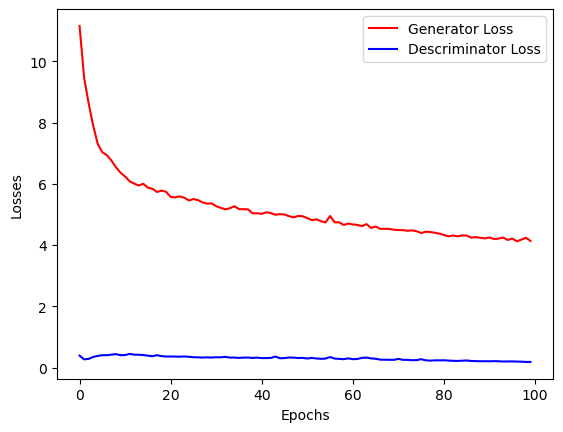

In [22]:
plot_gan_loss()

We can see that both loss functions gradually decrease over time which is what we would expect from a working model. In order to see the actual results we can plot same random photos and the corresponding Monet-esque Photos created by our model.

### Visualizing the neuron in the generator

In [ ]:
# # defines the generator class built upon convolutional layers
# class Visualize_Generator(nn.Module):
#     def __init__(self, in_ch, out_ch):
#         super().__init__()
#         """
#         model = list()
#         model.append(nn.ReflectionPad2d(3))
#         model.append(Convlayer(in_ch, 64, 7, 1, False, True, False))
#         model.append(Convlayer(64, 128, 3, 2, False))
#         model.append(Convlayer(128, 256, 3, 2, False))
#         for _ in range(num_res_blocks):
#             model.append(Resblock(256))
#         model.append(Upsample(256, 128))
#         model.append(Upsample(128, 64))
#         model.append(nn.ReflectionPad2d(3))
#         model.append(nn.Conv2d(64, out_ch, kernel_size=7, padding=0))
#         model.append(nn.Tanh())
#         """
#         model = list()
#         model.append(nn.Conv2d(in_ch, 64, 3, 2, 1, bias=True))
#         model.append(nn.ReLU())
        
#         model.append(nn.Conv2d(64, 128, 3, 1, 1, bias=True))
        
#         model.append(nn.Dropout(0.3))
#         model.append(nn.LeakyReLU(negative_slope=0.01,inplace=True))
#         model.append(nn.BatchNorm2d(128))
#         model.append(nn.Conv2d(128,256,5,2,1,bias=True))
        
# #         model.append(nn.LeakyReLU(negative_slope=0.03,inplace=True))
# #         model.append(nn.InstanceNorm2d(256))
# #         model.append(nn.ReflectionPad2d(1))
# #         model.append(nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1))
# #         model.append(nn.ReLU())
        
# #         model.append(nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=0))
# #         model.append(nn.Dropout(0.2))
# #         model.append(nn.LeakyReLU(negative_slope=0.01,inplace=True))
# #         model.append(nn.BatchNorm2d(64))
# #         model.append(nn.Conv2d(64, out_ch, kernel_size=6, padding=1))
# #         model.append(nn.Tanh())
#         self.gen = nn.Sequential(*model)

#     def forward(self, x):
#         return self.gen(x)

In [ ]:
# generator = Visualize_Generator(in_ch=3, out_ch=3)

# # Set the model to training mode (important for dropout layers)
# generator.train()

# # Create a random input image
# #input_image = torch.randn((1, 3, 256, 256), requires_grad=True)
# image_path = "../input/gan-getting-started/photo_jpg/00068bc07f.jpg"
# image = Image.open(image_path).convert("RGB")

# # Define image transformations to match the generator's input requirements
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Apply transformations to the image
# input_image = transform(image).unsqueeze(0).requires_grad_()

# # Forward pass
# output_image = generator(input_image)

# # Choose a specific layer and neuron for which you want to retain the gradient
# target_layer_index = 8  # Choose the index of the desired layer
# neuron_index = 0 # Choose the index of the neuron you want to retain the gradient for

# # Backward pass
# output_image[:, neuron_index, :, :].sum().backward(retain_graph=True)

# # Set gradients to zero for all neurons in the chosen layer except the specified neuron
# for i, layer in enumerate(generator.gen):
#     if i == target_layer_index:
#         for param in layer.parameters():
#             if param.grad is not None:
#                 param.grad[:, :, :, :] = 0.0
#                 param.grad[:, neuron_index, :, :].sum().backward()

# # Get the backpropagated image
# backprop_image = input_image.grad.data.numpy()[0]

# # Normalize the image values to be in the range [0, 1]
# backprop_image = (backprop_image - backprop_image.min()) / (backprop_image.max() - backprop_image.min())

# # Display the original and backpropagated images
# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(np.transpose(input_image.detach().numpy()[0], (1, 2, 0)))
# axes[0].set_title('Original Image')
# axes[0].axis('off')
# axes[1].imshow(np.transpose(backprop_image, (1, 2, 0)))
# axes[1].set_title('Backpropagated Image')
# axes[1].axis('off')
# plt.show()


### A plot to visualize every neuron

In [ ]:
# generator = Visualize_Generator(in_ch=3, out_ch=3)

# # Set the model to training mode (important for dropout layers)
# generator.train()

# # Load the image from the specified path
# image_path = "../input/gan-getting-started/photo_jpg/00068bc07f.jpg"
# image = Image.open(image_path).convert("RGB")

# # Define image transformations to match the generator's input requirements
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Apply transformations to the image
# input_image = transform(image).unsqueeze(0).requires_grad_()  # Add batch dimension and require gradient

# # Forward pass
# output_image = generator(input_image)

# # Choose a specific layer for which you want to retain the gradients
# target_layer_index = 8  # Choose the index of the desired layer

# # Get the number of neurons in the chosen layer
# num_neurons = list(generator.gen.children())[target_layer_index].out_channels

# # Create subplots for each neuron
# fig, axes = plt.subplots(num_neurons + 1, 1, figsize=(200, 200))

# # Display the original image
# axes[0].imshow(np.transpose(input_image.detach().numpy()[0], (1, 2, 0)))
# axes[0].set_title('Original Image')
# axes[0].axis('off')

# # Backward pass and display gradients for each neuron
# for neuron_index in range(num_neurons):
#     # Backward pass for the specific neuron
#     output_image[:, neuron_index, :, :].sum().backward(retain_graph=True)

#     # Get the gradients for the input image
#     input_image_gradients = input_image.grad.data.numpy()[0]

#     # Normalize the gradients for visualization
#     input_image_gradients = (input_image_gradients - input_image_gradients.min()) / (
#         input_image_gradients.max() - input_image_gradients.min()
#     )

#     # Display the gradients for the current neuron
#     axes[neuron_index + 1].imshow(np.transpose(input_image_gradients, (1, 2, 0)), cmap='gray')
#     axes[neuron_index + 1].set_title(f'Neuron {neuron_index}')
#     axes[neuron_index + 1].axis('off')

# plt.show()

### Visualizing the output image after passing through the entire generator

In [ ]:
# generator = Visualize_Generator(in_ch=3, out_ch=3)

# # Set the model to training mode (important for dropout layers)
# generator.train()

# # Load the image from the specified path
# image_path = "../input/gan-getting-started/photo_jpg/00068bc07f.jpg"
# image = Image.open(image_path).convert("RGB")

# # Define image transformations to match the generator's input requirements
# transform = transforms.Compose([
#     transforms.Resize((256, 256)),
#     transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Apply transformations to the image
# input_image = transform(image).unsqueeze(0).requires_grad_()  # Add batch dimension and require gradient

# # Forward pass
# output_image = generator(input_image)


# fig, axes = plt.subplots(1, 2, figsize=(10, 5))
# axes[0].imshow(np.transpose(input_image.detach().numpy()[0], (1, 2, 0)))
# axes[0].set_title('Original Image')
# axes[0].axis('off')
# axes[1].imshow(np.transpose(output_image.detach().numpy()[0],(1, 2, 0)))
# axes[1].set_title('Output Image')
# axes[1].axis('off')
# plt.show()

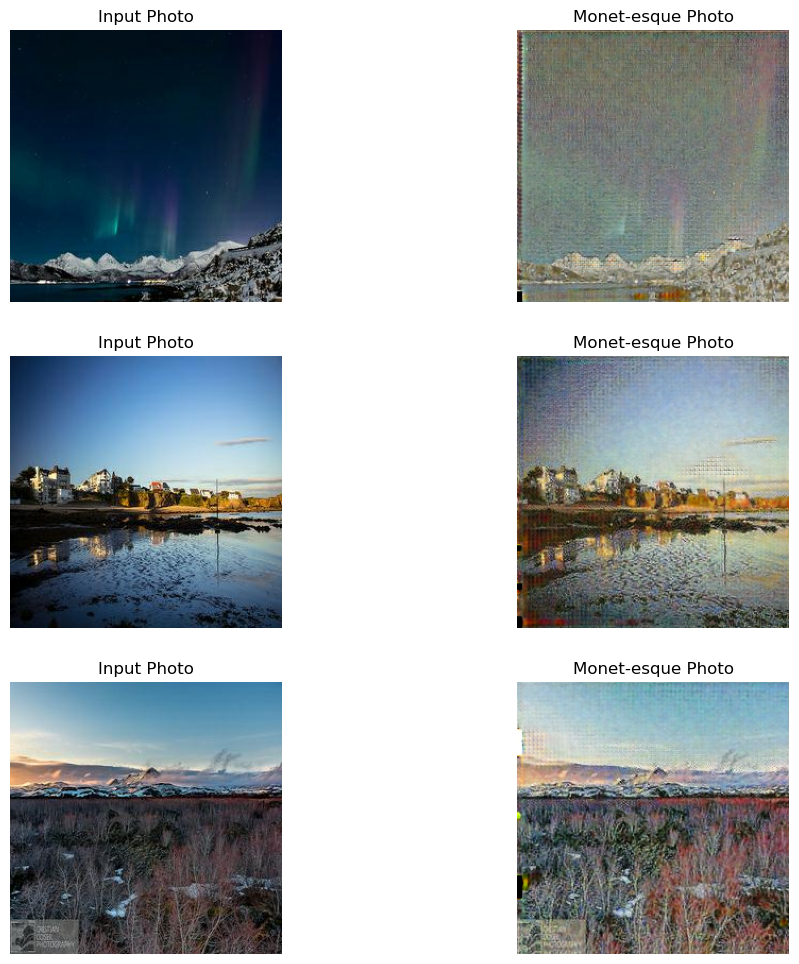

In [42]:
# plot realistic photo and created monet-style image 
_, ax = plt.subplots(3, 2, figsize=(12, 12))
for i in range(3):
    photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(photo_img.to(device)).cpu().detach()
    photo_img = reverse_normalize(photo_img)
    pred_monet = reverse_normalize(pred_monet)
    
    ax[i, 0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i, 1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque Photo")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

We can clearly see the difference and the expected monet-esque style. We talk about this in more detail in the Results and Analysis section. 

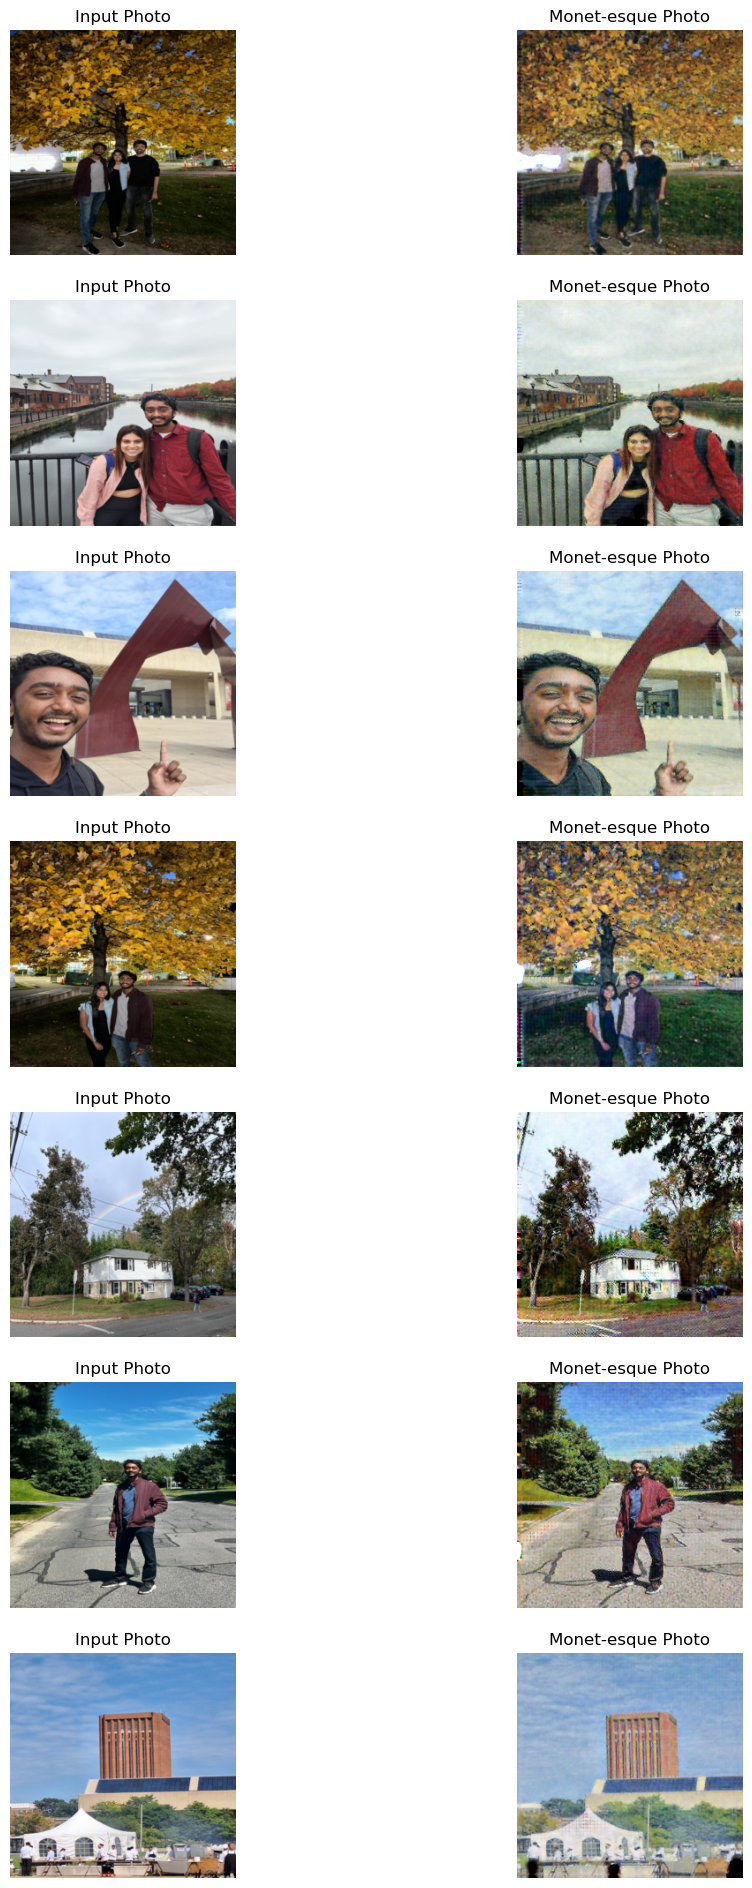

In [54]:
from glob import glob
_, ax = plt.subplots(7, 2, figsize=(12, 24))

for i,image_path in enumerate(glob("../input/sample-images/*")):
    #image_path = "../input/sample-images/IMG-20231202-WA0005.jpg"
    image = Image.open(image_path).convert("RGB")

    # Define image transformations to match the generator's input requirements
    transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

    input_image = transform(image).unsqueeze(0)


    #photo_img, _ = next(iter(img_dl))
    pred_monet = gan.gen_ptm(input_image.to(device)).cpu().detach()
    photo_img = reverse_normalize(input_image)
    pred_monet = reverse_normalize(pred_monet)

    ax[i,0].imshow(photo_img[0].permute(1, 2, 0))
    ax[i,1].imshow(pred_monet[0].permute(1, 2, 0))
    ax[i,0].set_title("Input Photo")
    ax[i,1].set_title("Monet-esque Photo")
    ax[i,0].axis("off")
    ax[i,1].axis("off")
plt.show()

## 5.5 Hyperparameter Tuning

For this project, I decided to manually tune some hyperparameters. An automated tuning process would result in training times that were too long considering the running time of the whole notebook is already quite long. Since the available usage time for the GPU on Kaggle is limited, I had to make some compromise by tuning only the learning rate and the beta value of the optimizer manually. I tried out different combination during the project, but only left the ones yielding the best results in the code see before. 

The values are the following:

* Starting learning rate: 2e-4
* Betas of optimizer: 0.5 and 0.999

Considering the limited resources in this project the results seem to be quite good. Of course, in an industrial scenario the tuning process has to be more sophisticated.

## 5.6 Alternative loss functions

During training I also experimented with an alternative optimizer, namely RMSprop instead of the Adam optimizer. RMSprop (Root Mean Square Propagation) is an adaptive learning rate optimization algorithm. Is uses a moving average of the squared gradients to adjust the learning rate, while Adam also includes a term to correct for bias (momentum). There are two main advantages using RMSprop. First, is can be more stable than Adam in some cases, as it doesn't include the momentum term, which might result in smaller updates and reduce the likelihood of divergence during training. And second, RMSprop can lead to faster convergence in certain situations, especially when dealing with non-stationary or noisy gradients. However, the final results did not differ much from the Adam optimizer, which is why I kept the Adam version in the code.

# 6. Results and Analysis

Now that we have trained our model we can use it to create the actual monet-like images from the provided photos in order to make a submission to the competition.

In [24]:
# class to store and access the photos (similar to the paintings done before)
class PhotoDataset(Dataset):
    def __init__(self, photo_dir, size=(256, 256), normalize=True):
        super().__init__()
        self.photo_dir = photo_dir
        self.photo_idx = dict()
        
        # normalize images if needed
        if normalize:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))                                
            ])
        else:
            self.transform = transforms.Compose([
                transforms.Resize(size),
                transforms.ToTensor()                               
            ])
        for i, fl in enumerate(os.listdir(self.photo_dir)):
            self.photo_idx[i] = fl

    # retrieve an image
    def __getitem__(self, idx):
        photo_path = os.path.join(self.photo_dir, self.photo_idx[idx])
        photo_img = Image.open(photo_path)
        photo_img = self.transform(photo_img)
        return photo_img

    def __len__(self):
        return len(self.photo_idx.keys())

In [27]:
# make a dataloader and the required directory for storing the images to be created
ph_ds = PhotoDataset(path_photo)
ph_dl = DataLoader(ph_ds, batch_size=1, pin_memory=True)
!mkdir ../images_v2
trans = transforms.ToPILImage()

In [28]:
# use model to create a monet style image
t = tqdm(ph_dl, leave=False, total=ph_dl.__len__())
for i, photo in enumerate(t):
    with torch.no_grad():
        pred_monet = gan.gen_ptm(photo.to(device)).cpu().detach()
    
    # revert the normalization process to obtain the original image style
    pred_monet = reverse_normalize(pred_monet)
    img = trans(pred_monet[0]).convert("RGB")
    
    # store the image
    img.save("../images_v2/" + str(i+1) + ".jpg")

  0%|          | 0/7038 [00:00<?, ?it/s]

In [29]:
# create a zip file from all created images
shutil.make_archive("/kaggle/working/images_v2", 'zip', "/kaggle/images_v2")

'/kaggle/working/images_v2.zip'

The generated zip file will be used by Kaggle to determine our place on the competition leaderboard. We can have a look at the images created for the submission. We can clearly recognize the typical monet style.

In [30]:
def display_sample_images(path, num_samples=16):
    sample_images = os.listdir(path)[:num_samples]
    
    w = int(num_samples ** .5)
    h = math.ceil(num_samples / w)
    
    for ind, image_name in enumerate(sample_images):
        img = cv2.imread(os.path.join(path, image_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
        plt.subplot(h, w, ind + 1)
        plt.imshow(img)
        plt.axis("off")
    
    plt.show()

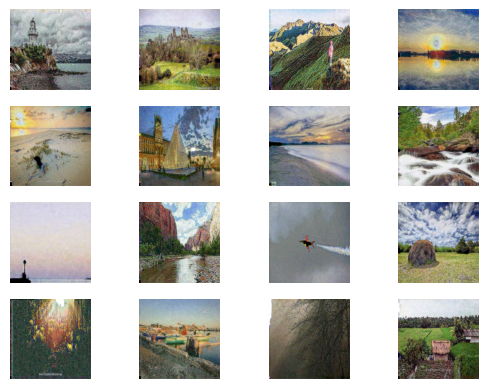

In [31]:
display_sample_images("../images_v2/")

In [32]:
# display best hyperparameters of model
learning_rate = [2e-4]
beta_1 = [0.5]
beta_2 = [0.999]  
df_results = pd.DataFrame({'Learning Rate': learning_rate, 'Beta 1': beta_1, 'Beta 2': beta_2})
print(df_results)

   Learning Rate  Beta 1  Beta 2
0         0.0002     0.5   0.999


As we can see from the resulting images during training and testing (= create submission images) we can confidently say that our model performed quite well with the shown set of hyperparameters above. If we had we more computing power we could automate this process of hyperparameter tuning even further to optimize the results. But for the context of this project the results are good enough thanks to the underlying CycleGAN model.

Since CycleGAN is effective for a wide range of image-to-image translation tasks, such as turning photos into paintings or converting day scenes to night scenes it also worked out well for our use case. Additionally, the adversarial training process helps generate high-quality, realistic images. Of course, there are other models we could explore. For example U-Net which is excellent for tasks that involve dense pixel-to-pixel correspondence, such as image segmentation. It even has a simpler architecture compared to GANs.

# 7. Conclusion

## 7.1 Result Summary

As we have already seen in the previous section, the CycleGAN network works really well with our images and the shown set of hyperparameters.

## 7.2 Learnings and Takeaways

Working with neural networks involves a distinct workflow compared to simpler supervised learning methods like regression analysis. Training models in this context can be time-consuming, sometimes taking hours. Therefore, maintaining a clean and precise work process is crucial to avoid excessive training iterations. An often underestimated but highly valuable practice in this regard is the strategic use of print statements within your code. These statements enable effective debugging, inspection of intermediate results, and quicker error identification. Another challenge I encountered during my work was the constrained memory and time resources of the GPU provided by Kaggle.

## 7.3 What didn't work

Overall, everything worked quite well. However, it would have been great to work with more epochs in order to get more precise results or perform an automated and more sohpisticated hyperparameter tuning. The limited GPU time really makes things a bit hard since processing image data requires so much disk space and computation time. It took quite a few iterations to find good values for the hyperparameters.

## 7.4 Possible improvements

If we had enough computing power, we could expand our hyperparameter tuning by including more parameters and a wider value range. We could also experiment with totally different model and compare their results.